#Classificação de imagens de roupas

### Sobre o projeto

* Estudo introdutório sobre Deep Learning, TensorFlow e Keras.

* E-commerce fictício de roupas, as roupas à venda devem ser classificadas em categorias para facilitar as buscas dos clientes no site.

* **Dataset:** [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que contém pequenas imagens (28x28) de roupas, associadas a 10 classes.

* **Referência:** Estudo desenvolvido acompanhando o curso [Deep Learning parte 1: Keras](https://cursos.alura.com.br/course/deep-learning-introducao-com-keras), da Alura.

# Abertura do dataset e primeiras visualizações

## Fashion MNIST

In [1]:
import tensorflow
from tensorflow import keras

dataset = keras.datasets.fashion_mnist

In [2]:
# retorna duas tuplas com conjuntos de treino, teste, e suas labels
((train_imgs, train_labels),(test_imgs, test_labels)) = dataset.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(f'Conjunto de treino possui {len(train_imgs)} imagens.')
print(f'Conjunto de teste possui {len(test_imgs)} imagens.')

Conjunto de treino possui 60000 imagens.
Conjunto de teste possui 10000 imagens.


In [4]:
print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28)
(10000, 28, 28)


## Classes

In [5]:
import numpy as np
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* Os nomes das classes estão no Readme do dataset.

In [6]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualização de alguns itens

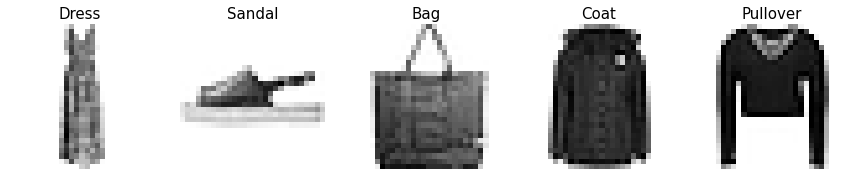

In [7]:
import random
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'

fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 60000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(train_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[train_labels[i]], fontsize = 15)

plt.show()

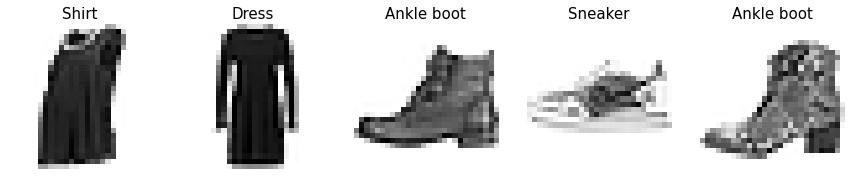

In [8]:
fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 10000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(test_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[test_labels[i]], fontsize = 15)

plt.show()

# Funções de Ativação

![teste](https://miro.medium.com/max/720/1*ZafDv3VUm60Eh10OeJu1vw.webp)

## ReLu

* Todos os número negativos se tornam 0.
* A ReLu tem a possibilidade de desligar alguns neurônios.
* $a = z^+ = max(0, z)$
* É não-linear, essencial para separar mais de duas características em uma única função.

## SoftMax

* Usada da última camada.
* Atribui probabilidades de cada categoria estar correta.

* ### $a_j^{(L-1)} = \frac{exp(z_j^{(L-1)})}{∑_i exp(z_i^{(L-1)})}$

  * (L-1) ⟶ camada anterior.
  * a > 0, por do exponencial.
  * O somatório de todas as probabilidades é 1, 100%.

# Construção do Modelo

* Modelo >> entrada > processamento > saída

* Na primeira camada, Camada 0, a imagem será "achatada" para um array de pixels de uma única dimensão.

* Na Camda 1, é feita a comunicação com a camada de entrada. Neste caso, será uma camada densa, totalmente conectada com a anterior.
  * No primneiro parâmetro, são definidos quantos neurônios estarão nesta camada.É interessante utilizar múltiplos de 2 por questão de processamento.
  * Deve ser definida também a função de ativação, que neste caso será a ReLu (https://www.tensorflow.org/api_docs/python/tf/nn/relu).

* Na Camada 2, de saída, terá o número de classificações do dataset e totalmente conectada.

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada 0, entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # camada 1, escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada 2, saída
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

* O batch_size padrão é 32, por isso a quantidade que aparece no log não é o tamanho completo do dataset, mas sim esse valor dividido por 32. Todo o dataset é usado no treinamento, mas em grupos menores.

In [11]:
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 4.0656


* O ideal é que a perda esteja o mais próximo de 0 possível.

# Redução de perda: Normalização

* Os pixels variam em um intervalo contínuo de 0 a 255.

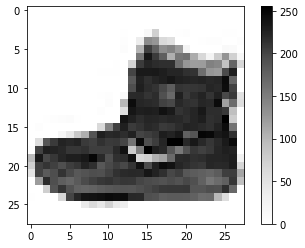

In [12]:
plt.imshow(train_imgs[0])
plt.colorbar()

* O valores serão normalizados para um intervalo de 0 a 1.

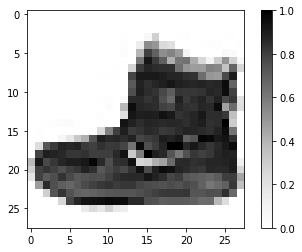

In [13]:
train_imgs = train_imgs/255.0

plt.imshow(train_imgs[0])
plt.colorbar()

# 2º Modelo: Valores normalizados [0, 1]

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4788


* Na execução desta observação, a perda foi reduzida de 4.4171 para 0.4825.

* Reduzir a amplitude numérica que a rede precisou processar ajudou muito a evitar perda de informação.

* As gradações das imagens se mantiveram, a roupa usada como exemplo anteriormente continuou sendo visualmente identificável, e ainda houve melhoria no modelo.

# Redução de perda: Reestruturação das camadas escondidas

* Da segunda camada para a camada de saída há conexões de 256 para 10. 

* A ideia do próximo passo é afunilar estas conexões criando uma camada internediária e verificar se a perda é reduzida.

## Segunda camada escondida: 128 neurônios

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada de entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # primeira camada escondida
    keras.layers.Dense(128, activation = tensorflow.nn.relu),   # nova camda escondida, segunda camada
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada de saída
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 8s 4ms/step - loss: 0.4750


* Na execução desta observação, a perda foi reduzida de 0.4825 para 0.4777.

## Terceira camada escondida: 64 neurônios

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(64, activation = tensorflow.nn.relu),    # terceira camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 8s 4ms/step - loss: 0.4855


* Na execução desta observação, a perda foi incrementada de 0.4777 para 0.4854.

* Neste caso de estudo, o aumento do tempo de execução foi irrelevante.

* Aumentar a quantidade de camadas escondidas, tornando a rede mais profunda, nem sempre trará benefícios para o modelo, além de poder aumentar significativamente o tempo de execução em modelos de aplicação real.

* Tanto a quantidade de neurônios quanto as funções de ativação precisarão de uma exploração, um processo mais subjetivo do que exato.

# 3º Modelo: Normalização e 2 camadas escondidas

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.4743


# Redução de perda: Quantidade de épocas

* Épocas são os contatos que o modelo tem com o dataset no processo de aprendizagem, em que os ajustes de pesos das conexões são feitas entre os neurônios.

* A seguir, as quantidades de épocas serão alteradas para análise da sua influência na perda.

* O tempo de execução terá um aumento linear, diretamente proporcional à execução com somento uma época.

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4749
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3610
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3244
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3004
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2822


* A perda foi diminindo gradativamente, mas mesmo neste dataset de estudo o aumento de tempo já foi perceptível.

# 4º Modelo: Normalização, 2 camadas escondidas, 5 épocas

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4715 - accuracy: 0.8298
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3594 - accuracy: 0.8677
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3259 - accuracy: 0.8791
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3008 - accuracy: 0.8876
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2816 - accuracy: 0.8945


# Métrica de avaliação: Acurácia

* A acurácia irá medir o quanto o modelo está acertando.

* O ideal é que, à medida que o modelo é reestruturado, a perda diminua e a acurácia aumente.

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4776 - accuracy: 0.8263
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3604 - accuracy: 0.8672
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3254 - accuracy: 0.8811
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2996 - accuracy: 0.8890
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2821 - accuracy: 0.8963


* A acurácia aumentou de acordo com a quantidade de épocas executadas.

# Testes do Modelo

## Elemento a elemento

* Sobre o modelo com as aletrações: imagens normalizadas, segunda camada escondida e 5 épocas.

In [21]:
testes = model.predict(test_imgs)

313/313 [==============================] - 1s 2ms/step


In [22]:
testes[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99999994],
      dtype=float32)

In [23]:
np.argmax(testes[0])

9

* A Softmax, usada na camada de saída, retorna a probabilidade de uma entrada pertencer a cada categoria.

* No primeiro item do dataset, demonstrado acima, foi calculada uma probabilidade de quase 100% da imagem representar um item da última classe.

In [24]:
print(f'Resultado do teste: {np.argmax(testes[0])}')
print(f'Número da imagem de teste: {test_labels[0]}')

Resultado do teste: 9
Número da imagem de teste: 9


## Evaluate

* 1º Resultados: Perda do teste
* 2º Resultado: Acurácia do teste

In [25]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 58.5007 - accuracy: 0.8511
Perda: 58.50068664550781
Acuráci: 0.8511000275611877


In [26]:
test_imgs_normalized = test_imgs/255

test_loss, test_accuracy = model.evaluate(test_imgs_normalized, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3557 - accuracy: 0.8735
Perda: 0.3556540906429291
Acuráci: 0.8734999895095825


## Conjunto de Validação

* Com a definição do validation_split, o treinamento passa a separar um conjunto para validação do modelo.

* Os valores de perda e acurácia da validação são retornados junto com os do treino.

In [27]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4958 - accuracy: 0.8233 - val_loss: 0.3828 - val_accuracy: 0.8617
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3684 - accuracy: 0.8661 - val_loss: 0.3705 - val_accuracy: 0.8651
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3346 - accuracy: 0.8776 - val_loss: 0.3373 - val_accuracy: 0.8780
Epoch 4/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3079 - accuracy: 0.8853 - val_loss: 0.3704 - val_accuracy: 0.8694
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2881 - accuracy: 0.8921 - val_loss: 0.3248 - val_accuracy: 0.8836


# Gráficos de Acurácia e Perda

## Análise de 5 épocas

In [28]:
historico.history

{'loss': [0.4958003759384155,
  0.36843207478523254,
  0.3345933258533478,
  0.3078816831111908,
  0.2881490886211395],
 'accuracy': [0.823312520980835,
  0.8661041855812073,
  0.8776458501815796,
  0.8852708339691162,
  0.8921250104904175],
 'val_loss': [0.38280802965164185,
  0.3705156147480011,
  0.33727946877479553,
  0.37040087580680847,
  0.324750691652298],
 'val_accuracy': [0.8616666793823242,
  0.8650833368301392,
  0.878000020980835,
  0.8694166541099548,
  0.8835833072662354]}

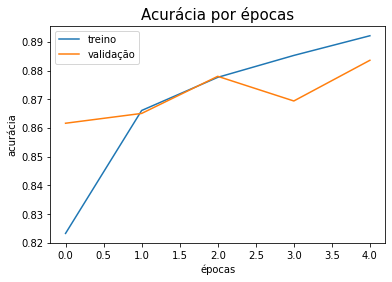

In [29]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

* A acurácia aumentou no decorrer das 5 épocas. Portanto, seguiu como desejado.

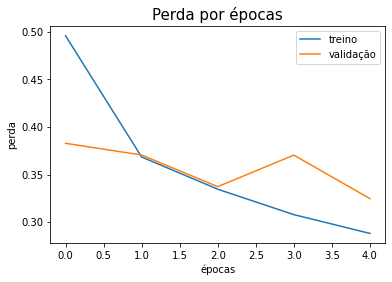

In [30]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* A perda diminuiu no decorrer das 5 épocas. Também seguiu como desejado.

## Análise de 10 épocas

In [31]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 10, validation_split = 0.2)

Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4926 - accuracy: 0.8223 - val_loss: 0.3837 - val_accuracy: 0.8635
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3653 - accuracy: 0.8660 - val_loss: 0.3738 - val_accuracy: 0.8642
Epoch 3/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3309 - accuracy: 0.8777 - val_loss: 0.3365 - val_accuracy: 0.8783
Epoch 4/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3051 - accuracy: 0.8864 - val_loss: 0.3171 - val_accuracy: 0.8842
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2853 - accuracy: 0.8930 - val_loss: 0.3326 - val_accuracy: 0.8788
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2755 - accuracy: 0.8969 - val_loss: 0.3218 - val_accuracy: 0.8849
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2602 - accuracy: 0.9033 - val_loss: 0.3416 - val_accuracy:

### Acurácia

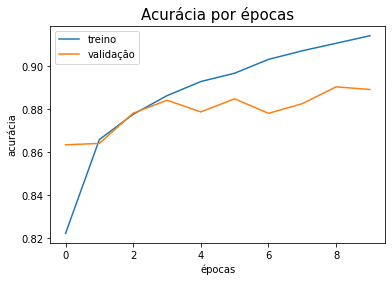

In [32]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

* A Acurácia do treino sobe de forma consistente, mas a de validação não só não consegue aumentar o suficiente para acompanhá-la como oscila no decorrer das épocas.

### Perda

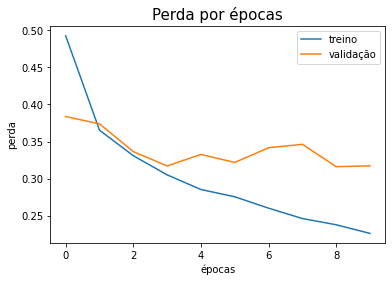

In [33]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* Algo semelhante acontece com os valores de perda, a validação não consegue acompanhar o treino.

* Os dois gráficos sugereme o modelo está sofrendo um Overfitting, ou seja, está tão especializado nos padrões das imagens de treinamento que não consegue interpretar novas imagens, do conjunto de validação.

* Para evitar o oferfitting, pode-se manter a quantidade de épocas no intervalo em que os resultados estão mais estáveis. Onde a tendência da perda e da acurácia estão favoráveis no treino e os resultados na validação ainda estão próximos.

* Neste caso, entre [4, 6]. Será mantido o 4º modelo.

# Mais alterações nas camadas escondidas

## Dropout

* Irá inativar algumas ligações entre duas camadas, como se os neurônios estivessem inativos. Recebe uma porcentagem de ligações que serão desligadas.

* Pode ser considerado uma Normalização.

In [34]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dropout(0.2),  # nova camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5202 - accuracy: 0.8128 - val_loss: 0.3933 - val_accuracy: 0.8562
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3851 - accuracy: 0.8587 - val_loss: 0.3560 - val_accuracy: 0.8694
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3435 - accuracy: 0.8719 - val_loss: 0.3544 - val_accuracy: 0.8681
Epoch 4/5
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3206 - accuracy: 0.8814 - val_loss: 0.3429 - val_accuracy: 0.8765
Epoch 5/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3022 - accuracy: 0.8882 - val_loss: 0.3397 - val_accuracy: 0.8736


### Gráficos de Validação

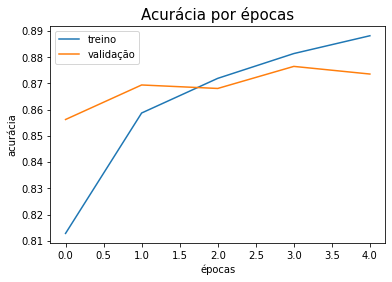

In [35]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

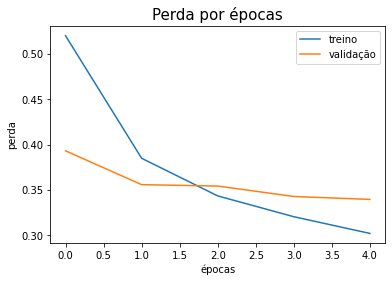

In [36]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* O comportamento das curvas de validação melhoraram em comparação com o modelo sem Dropout. Apesar dos resultados de treino serem um pouco piores, a perda e acurácia da validação estão melhores.

# Salvando e utilizando modelo treinado

In [37]:
model.save('model.h5')

In [38]:
from tensorflow.keras.models import load_model

saved_model = load_model('model.h5')

In [39]:
tests = saved_model.predict(test_imgs_normalized)
print(f'Resultado do teste: {np.argmax(tests[0])}')
print(f'Rótulo da imagem: {test_labels[0]}')

313/313 [==============================] - 1s 3ms/step
Resultado do teste: 9
Rótulo da imagem: 9


# Análises sobre o modelo e teoria

* A partir daqui, foram feitos alguns exercícios do curso para fixar conceitos relacionados às Redes Neurais. Não necessariamente têm uma aplicação prática.

## Sumário, descrição das camadas

In [40]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               200960    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


* O Param # mostra a quantidade de parâmetros que são considerados na camada.
  * 1º há apenas o achatamento, o valor ficou 0
  * 2º (784 (achatamento 28x28) + 1 (viés)) x 256 (neurônios) 
  * 3º 256 (valores propagados da camada anterior) x 128 (neurônios) + 128 (pesos)
  * 4º Dropout 20%
  * 5º 128 (valores propagados) x 10 (neurônios) + 10 (pesos)

* Os pesos são calculadosn e otimizados nas etapas de backpropagation.

### Pesos da primeira camada Dense

In [45]:
model.layers[1].get_weights()[0]

array([[-0.02886431,  0.03141145,  0.14719513, ..., -0.05172582,
         0.03383387,  0.07651757],
       [-0.04977333,  0.00920796,  0.06995192, ..., -0.00105661,
         0.0630625 ,  0.16767558],
       [ 0.03234804,  0.1182477 ,  0.00921446, ...,  0.05370774,
        -0.00440575,  0.19454457],
       ...,
       [ 0.03432364,  0.05822747, -0.17906152, ...,  0.05495149,
         0.13937211,  0.16215996],
       [-0.09116857,  0.15424785, -0.03871771, ..., -0.02673548,
         0.08064268, -0.06815667],
       [-0.07305832,  0.24564926,  0.06530512, ..., -0.09183856,
         0.04328014,  0.01265766]], dtype=float32)

### Vieses da primeira camada Dense

* Os Vieses indicam o que está mais próximo ou mais distante de conseguir o resultado esperado.
  * Por exemplo: uma saia está mais próxima de um vestido do que de um sapato.

In [48]:
len(model.layers[1].get_weights()[1])

256

In [47]:
model.layers[1].get_weights()[1]

array([ 5.12790494e-02,  1.81695491e-01,  1.26245081e-01,  9.32416618e-02,
        2.26295218e-01, -3.42362106e-01, -2.89601326e-01, -1.81664258e-01,
       -4.73947302e-02, -4.02560644e-03,  3.06154341e-01, -1.21519379e-02,
       -6.10164255e-02,  3.07216700e-02,  2.04684243e-01,  2.55073309e-02,
       -7.43365288e-02,  1.42830506e-01,  2.24064991e-01,  5.79655208e-02,
       -1.68132350e-01,  3.62446189e-01,  1.09486513e-01,  4.71248664e-02,
        1.29161462e-01, -1.04283001e-02,  1.50125921e-01,  9.42455754e-02,
        1.71484761e-02, -1.80865660e-01,  1.96737543e-01,  1.84363425e-01,
       -3.64599347e-01, -1.42155250e-03,  1.51293665e-01, -3.06226373e-01,
        1.11999132e-01,  1.21305145e-01,  2.01849893e-01, -6.72782119e-03,
        8.78343955e-02,  4.21750635e-01,  2.88193583e-01, -1.77467782e-02,
        1.46704197e-01,  3.35837603e-02, -2.44346261e-02,  1.63140744e-01,
       -1.08630650e-01, -2.83117983e-02, -1.35091320e-02,  5.13923466e-02,
       -1.44391805e-01, -

## Alterando pesos "à mão"

### Pesos 0

In [52]:
vieses_camada_dense = model.layers[1].get_weights()[1]
print(f'Vieses: {vieses_camada_dense.shape}')
pesos_camada_dense = model.layers[1].get_weights()[0]
print(f'Pesos: {pesos_camada_dense.shape}')

Vieses: (256,)
Pesos: (784, 256)


In [53]:
pesos_camada_dense_zerados = np.zeros((784, 256))
model.layers[1].set_weights([pesos_camada_dense_zerados, vieses_camada_dense])

In [54]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5312 - accuracy: 0.8050 - val_loss: 0.4472 - val_accuracy: 0.8261
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3883 - accuracy: 0.8570 - val_loss: 0.3954 - val_accuracy: 0.8492
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3517 - accuracy: 0.8706 - val_loss: 0.3525 - val_accuracy: 0.8713
Epoch 4/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3315 - accuracy: 0.8774 - val_loss: 0.3418 - val_accuracy: 0.8741
Epoch 5/5
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3131 - accuracy: 0.8840 - val_loss: 0.3566 - val_accuracy: 0.8748


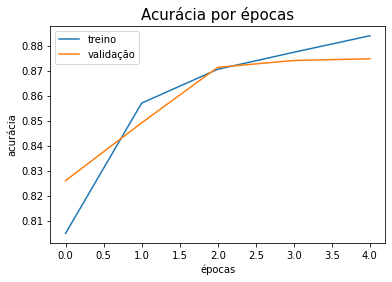

In [55]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

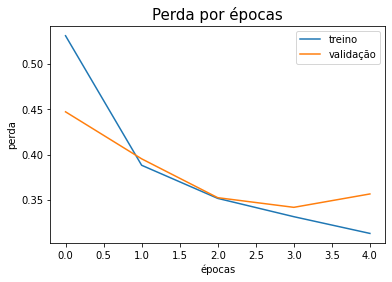

In [56]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()